# Import Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from pandas import DataFrame
from time import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

#metrics & evaluation
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
precision_score, recall_score
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

#plotting tools
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from matplotlib import pyplot as plt
import seaborn as sns

#nlp tools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob
from nltk import pos_tag

# Read into Python

In [2]:
#load dataset
df = pd.read_csv('/Users/madhukumar/Desktop/Portfolio/github/glassdoor-sentiment/data/employee_reviews_with_features.csv')
df.head()

,Unnamed: 0,full_review,clean_review,country,word_count,label,class
0,0,Best Company to work for. People are smart and...,best company to work for people are smart and ...,none,16,positive,1
1,1,"Moving at the speed of light, burn out is inev...",moving at the speed of light burn out is inevi...,United States of America,708,positive,1
2,2,Great balance between big-company security and...,great balance between bigcompany security and ...,United States of America,805,positive,1
3,3,The best place I've worked and also the most d...,the best place ive worked and also the most de...,United States of America,836,positive,1
4,4,"Unique, one of a kind dream job. Google is a w...",unique one of a kind dream job google is a wor...,United States of America,2281,positive,1


In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.rename(columns={'clean_review':'text'}, inplace=True)

In [5]:
df.head()

,full_review,text,country,word_count,label,class
0,Best Company to work for. People are smart and...,best company to work for people are smart and ...,none,16,positive,1
1,"Moving at the speed of light, burn out is inev...",moving at the speed of light burn out is inevi...,United States of America,708,positive,1
2,Great balance between big-company security and...,great balance between bigcompany security and ...,United States of America,805,positive,1
3,The best place I've worked and also the most d...,the best place ive worked and also the most de...,United States of America,836,positive,1
4,"Unique, one of a kind dream job. Google is a w...",unique one of a kind dream job google is a wor...,United States of America,2281,positive,1


In [6]:
df.shape

(66935, 6)

In [7]:
df.isnull().sum()

full_review    0
text           0
country        0
word_count     0
label          0
class          0
dtype: int64

In [8]:
df.label.value_counts()

positive    60499
negative     5811
neutral       625
Name: label, dtype: int64

In [9]:
df['label'].value_counts() / len(df.text)

positive    0.903847
negative    0.086816
neutral     0.009337
Name: label, dtype: float64

Target class is highly imbalanced

# Resampling

In [10]:
X = df[['text', 'class']]
y = df['class']

In [11]:
X['class'].value_counts()

1    60499
0     5811
2      625
Name: class, dtype: int64

In [12]:
X = df[['text', 'class']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state= 2000)

In [13]:
X_train.shape

(65596, 2)

In [14]:
# separate minority and majority classes
negative = X_train[X_train['class'] == 2]
positive = X_train[X_train['class'] == 1]
neutral = X_train[X_train['class'] == 0]

In [17]:
# upsample minority class
negative_upsampled = resample(negative,
                          replace=True, # sample with replacement
                          n_samples=len(positive), # match number in majority class
                          random_state=27) # reproducible results

neutral_upsampled = resample(negative,
                          replace=True, # sample with replacement
                          n_samples=len(positive), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
df_resampled = pd.concat([positive, neutral, negative_upsampled])

# check new class counts
df_resampled['class'].value_counts()

df_resampled.head()

,text,class
13079,seasonal campus associtate great work environm...,1
3391,super fun but plenty of ineffeciencies super p...,1
46974,business specialist professional environment p...,1
62693,facilities coordinator great place laid out cu...,1
42170,genius great customer service job stability go...,1


In [19]:
df_resampled.shape

(124288, 2)

In [21]:
df_resampled['class'].value_counts()

2    59296
1    59296
0     5696
Name: class, dtype: int64

# Lemmatization

In [22]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = str(text).lower()
    words = TextBlob(str(text)).words
    return [word.lemmatize() for word in words]

# Bag of Words - Vectorization

# (1) CountVectorizer

In [23]:
cvec = CountVectorizer()

In [24]:
stop = stopwords.words('english') 
#in case custom stopwords will be requires
additional_stopwords = """ """

stop += additional_stopwords.split()

In [25]:
# use split_into_lemmas as the feature extraction function (WARNING: SLOW!)
vect = CountVectorizer(stop_words=stop, analyzer=split_into_lemmas)

In [26]:
# Fitting the vectorizer on our training data
cvec.fit(df['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [27]:
# Lets check the length of our data that is in a vectorized state
len(cvec.get_feature_names())

49402

# Null Accuracy (Baseline)

In [28]:
y = df['class']

In [29]:
# examine the class distribution of the testing set (using a Pandas Series method)
y.value_counts()

1    60499
0     5811
2      625
Name: class, dtype: int64

In [30]:
# calculate the percentage
y.value_counts()/len(y)

1    0.903847
0    0.086816
2    0.009337
Name: class, dtype: float64

In [31]:
# calculate null accuracy (for multi-class classification problems)
y.value_counts().head(1) / len(y)

1    0.903847
Name: class, dtype: float64

# Classification Models

In [48]:
X_train = df_resampled['text']
y_train = df_resampled['class']

X = df['text']
y = df['label']

SEED = 2000
X_train_null, X_test, y_train_null, y_test = train_test_split(X, y, test_size=.02, random_state=SEED)
                                                                                  
# Use CountVectorizer
vect = CountVectorizer(stop_words=stop, tokenizer = word_tokenize, analyzer=split_into_lemmas, min_df=0.0001,
                      max_df = 0.80)

# Create document-term matrices
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Use LogReg to predict the target class
LogReg = LogisticRegression(C=0.2, solver='lbfgs', dual=False, multi_class='multinomial')
LogReg.fit(X_train_dtm, y_train)
y_pred_class = LogReg.predict(X_test_dtm)

# Calculate accuracy
print((metrics.accuracy_score(y_test, y_pred_class)))
print(classification_report(y_test, LogReg.predict(X_test_dtm)))

0.0


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



ValueError: Mix of label input types (string and number)

# Feature Comparison and Selection

- To see if we can improve accuracy scores from the above model
- Comparing n-grams and vectorization models

In [44]:
X = df['text']
y = df['label']

SEED = 2000
X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.02, 
                                                                                  random_state=SEED)

X_validation, X_test, y_validation, y_test = train_test_split(X_validation_and_test, 
                                                              y_validation_and_test, test_size=.5, random_state=SEED)

In [45]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    
    null_accuracy = 0.54
    
    t0 = time()
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(("f1 score: {0:.2f}").format(f1))
    
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
        
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [46]:
cvec = CountVectorizer()
tvec= TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(1000,10001,1000)


def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=stop, ngram_range=(1, 1), classifier=lr):
    result = []
    
    print (classifier)
    print ("\n")
    
    for n in n_features:
        max_features=n
        vectorizer.set_params(stop_words=stop, max_features=n, ngram_range=ngram_range)
        
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result


In [47]:
def nfeature_accuracy_checker_forhash(vectorizer=cvec, n_features=n_features, stop_words=stop, ngram_range=(1, 1), classifier=lr):
    result = []
    
    print (classifier)
    print ("\n")
    
    for n in n_features:
        max_features=n
        vectorizer.set_params(stop_words=stop, n_features=n, ngram_range=ngram_range)
        
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result

In [48]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 1000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.89
null accuracy: 54.00%
accuracy score: 91.18%
model is 37.18% more accurate than null accuracy
train and test time: 4.34s
--------------------------------------------------------------------------------
Validation result for 2000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 92.08%
model is 38.08% more accurate than null accuracy
train and test time: 4.15s
--------------------------------------------------------------------------------
Validation result for 3000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 92.08%
model is 38.08% more accurate than null accuracy
train and test time: 4.17s
--------------------------------------------------------------------------------
Validation result for 4000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 91.93%
model is 37.93% more accurate than null accuracy
train and test time: 4.57s
--------------------------------------------------------------------------------
Validation result for 5000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 92.08%
model is 38.08% more accurate than null accuracy
train and test time: 4.42s
--------------------------------------------------------------------------------
Validation result for 6000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 91.78%
model is 37.78% more accurate than null accuracy
train and test time: 4.74s
--------------------------------------------------------------------------------
Validation result for 7000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 91.93%
model is 37.93% more accurate than null accuracy
train and test time: 4.40s
--------------------------------------------------------------------------------
Validation result for 8000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 91.93%
model is 37.93% more accurate than null accuracy
train and test time: 4.90s
--------------------------------------------------------------------------------
Validation result for 9000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 91.93%
model is 37.93% more accurate than null accuracy
train and test time: 4.61s
--------------------------------------------------------------------------------
Validation result for 10000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.90
null accuracy: 54.00%
accuracy score: 91.78%
model is 37.78% more accurate than null accuracy
train and test time: 4.73s
--------------------------------------------------------------------------------
CPU times: user 42.8 s, sys: 1.05 s, total: 43.8 s
Wall time: 45.1 s


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [49]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (CountVectorizer)\n")
feature_result_ugc = nfeature_accuracy_checker(vectorizer=cvec)

RESULT FOR UNIGRAM WITH STOP WORDS (CountVectorizer)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 1000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.89
null accuracy: 54.00%
accuracy score: 91.03%
model is 37.03% more accurate than null accuracy
train and test time: 5.54s
--------------------------------------------------------------------------------
Validation result for 2000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.91
null accuracy: 54.00%
accuracy score: 92.08%
model is 38.08% more accurate than null accuracy
train and test time: 7.52s
--------------------------------------------------------------------------------
Validation result for 3000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.91
null accuracy: 54.00%
accuracy score: 92.23%
model is 38.23% more accurate than null accuracy
train and test time: 8.84s
--------------------------------------------------------------------------------
Validation result for 4000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.91
null accuracy: 54.00%
accuracy score: 92.23%
model is 38.23% more accurate than null accuracy
train and test time: 9.80s
--------------------------------------------------------------------------------
Validation result for 5000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.91
null accuracy: 54.00%
accuracy score: 92.53%
model is 38.53% more accurate than null accuracy
train and test time: 10.32s
--------------------------------------------------------------------------------
Validation result for 6000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.91
null accuracy: 54.00%
accuracy score: 92.53%
model is 38.53% more accurate than null accuracy
train and test time: 11.80s
--------------------------------------------------------------------------------
Validation result for 7000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.92
null accuracy: 54.00%
accuracy score: 92.97%
model is 38.97% more accurate than null accuracy
train and test time: 9.82s
--------------------------------------------------------------------------------
Validation result for 8000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.91
null accuracy: 54.00%
accuracy score: 92.68%
model is 38.68% more accurate than null accuracy
train and test time: 9.82s
--------------------------------------------------------------------------------
Validation result for 9000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.92
null accuracy: 54.00%
accuracy score: 92.83%
model is 38.83% more accurate than null accuracy
train and test time: 10.32s
--------------------------------------------------------------------------------
Validation result for 10000 features


/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/madhukumar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.92
null accuracy: 54.00%
accuracy score: 92.68%
model is 38.68% more accurate than null accuracy
train and test time: 11.34s
--------------------------------------------------------------------------------
CPU times: user 1min 30s, sys: 1.39 s, total: 1min 31s
Wall time: 1min 35s


In [122]:
hvec = HashingVectorizer()

In [182]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (Hashing)\n")
feature_result_ugh = nfeature_accuracy_checker_forhash(vectorizer=hvec)

RESULT FOR UNIGRAM WITH STOP WORDS (Hashing)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 86.03%
model is 32.03% more accurate than null accuracy
train and test time: 1.02s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 87.07%
model is 33.07% more accurate than null accuracy
train and test time: 1.00s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 91.21%
model is 37.21% more accurate than null accuracy
train and test time: 0.82s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 91.03%
model is 37.03% more accurate than null accuracy
train and test time: 0.65s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 91.21%
mod

In [183]:
%%time
print ("RESULT FOR BIGRAMS WITH STOP WORDS (Tfidf)\n")
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAMS WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 91.38%
model is 37.38% more accurate than null accuracy
train and test time: 1.24s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 93.28%
model is 39.28% more accurate than null accuracy
train and test time: 0.98s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 93.79%
model is 39.79% more accurate than null accuracy
train and test time: 1.06s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 93.79%
model is 39.79% more accurate than null accuracy
train and test time: 1.09s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 93.97%
mod

In [184]:
%%time
print ("RESULT FOR BIGRAMS WITH STOP WORDS (CountVectorizer)\n")
feature_result_bgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))

RESULT FOR BIGRAMS WITH STOP WORDS (CountVectorizer)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 92.24%
model is 38.24% more accurate than null accuracy
train and test time: 1.20s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 94.14%
model is 40.14% more accurate than null accuracy
train and test time: 1.05s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 94.66%
model is 40.66% more accurate than null accuracy
train and test time: 1.04s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 95.17%
model is 41.17% more accurate than null accuracy
train and test time: 1.07s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 95.17%
mod

In [185]:
%%time
print ("RESULT FOR BIGRAMS WITH STOP WORDS (Hashing)\n")
feature_result_bgh = nfeature_accuracy_checker_forhash(vectorizer=hvec,ngram_range=(1, 2))

RESULT FOR BIGRAMS WITH STOP WORDS (Hashing)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 85.34%
model is 31.34% more accurate than null accuracy
train and test time: 1.00s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 87.07%
model is 33.07% more accurate than null accuracy
train and test time: 1.12s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 89.83%
model is 35.83% more accurate than null accuracy
train and test time: 0.88s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 89.66%
model is 35.66% more accurate than null accuracy
train and test time: 0.94s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 90.00%
mod

In [186]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 91.55%
model is 37.55% more accurate than null accuracy
train and test time: 1.41s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 93.28%
model is 39.28% more accurate than null accuracy
train and test time: 1.25s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 93.62%
model is 39.62% more accurate than null accuracy
train and test time: 1.89s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 93.62%
model is 39.62% more accurate than null accuracy
train and test time: 1.17s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 93.79%
mod

In [187]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (CountVectorizer)\n")
feature_result_tgc = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (CountVectorizer)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 92.07%
model is 38.07% more accurate than null accuracy
train and test time: 1.54s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 94.31%
model is 40.31% more accurate than null accuracy
train and test time: 1.23s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 94.48%
model is 40.48% more accurate than null accuracy
train and test time: 1.31s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 94.83%
model is 40.83% more accurate than null accuracy
train and test time: 1.27s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 95.00%
mod

In [188]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Hashing)\n")
feature_result_tgh = nfeature_accuracy_checker_forhash(vectorizer=hvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Hashing)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 1000 features


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



null accuracy: 54.00%
accuracy score: 84.31%
model is 30.31% more accurate than null accuracy
train and test time: 1.10s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 54.00%
accuracy score: 85.00%
model is 31.00% more accurate than null accuracy
train and test time: 1.26s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 54.00%
accuracy score: 88.79%
model is 34.79% more accurate than null accuracy
train and test time: 0.86s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 54.00%
accuracy score: 87.93%
model is 33.93% more accurate than null accuracy
train and test time: 0.90s
--------------------------------------------------------------------------------
Validation result for 5000 features
null accuracy: 54.00%
accuracy score: 89.83%
mod

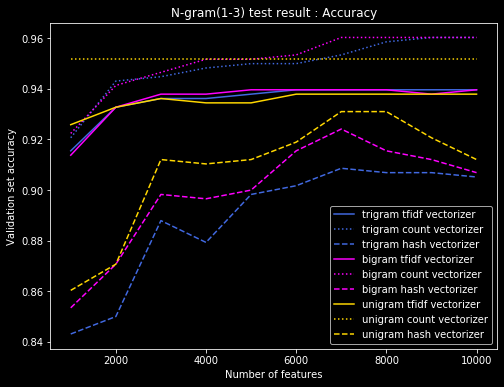

In [201]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tgc = pd.DataFrame(feature_result_tgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgc = pd.DataFrame(feature_result_bgc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugc = pd.DataFrame(feature_result_ugc,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tgh = pd.DataFrame(feature_result_tgh,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgh = pd.DataFrame(feature_result_bgh,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugh = pd.DataFrame(feature_result_ugh,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tgc.nfeatures, nfeatures_plot_tgc.validation_accuracy,label='trigram count vectorizer',
         linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_tgh.nfeatures, nfeatures_plot_tgh.validation_accuracy,label='trigram hash vectorizer',
         linestyle='--', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='magenta')
plt.plot(nfeatures_plot_bgc.nfeatures, nfeatures_plot_bgc.validation_accuracy,label='bigram count vectorizer',
         linestyle=':', color='magenta')
plt.plot(nfeatures_plot_bgh.nfeatures, nfeatures_plot_bgh.validation_accuracy,label='bigram hash vectorizer',
         linestyle='--', color='magenta')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ugc.nfeatures, nfeatures_plot_ugc.validation_accuracy, label='unigram count vectorizer',
         linestyle=':', color='gold')
plt.plot(nfeatures_plot_ugh.nfeatures, nfeatures_plot_ugh.validation_accuracy, label='unigram hash vectorizer',
         linestyle='--', color='gold')

plt.title("N-gram(1-3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# Model Comparison

In [221]:
names = ["Logistic Regression", "Random Forest Classifier","Multinomial NB", 
         "Support Vector Machine", "XGBoost"]

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    MultinomialNB(),
    SVC(kernel='linear'),
    XGBClassifier(),
    ]

zipped_clf = zip(names, classifiers)

In [222]:
cvec = CountVectorizer()

def classifier_comparator(vectorizer=cvec, n_features=10000, stop_words=stop, ngram_range=(1, 1), 
                          classifier=zipped_clf):
    result = []
    
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
        
    return result


In [223]:
%%time
bigram_result = classifier_comparator(n_features=100000,ngram_range=(1,2))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



f1 score: 0.97
null accuracy: 54.00%
accuracy score: 96.90%
model is 42.90% more accurate than null accuracy
train and test time: 1.47s
--------------------------------------------------------------------------------
Validation result for Random Forest Classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



f1 score: 0.97
null accuracy: 54.00%
accuracy score: 96.90%
model is 42.90% more accurate than null accuracy
train and test time: 7.71s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
f1 score: 0.88
null accuracy: 54.00%
accuracy score: 87.24%
model is 33.24% more accurate than null accuracy
train and test time: 0.61s
--------------------------------------------------------------------------------
Validation result for Support Vector Machine
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
f1 score: 0.97
null accuracy: 54.00%
accuracy score: 97.24%
model is 43.24% more accurate than null accuracy
train and test time: 127.17s
------------------------------------------------

Random Forest Classifier performs best

In [406]:

X = upsampled['text']
y = upsampled['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


vect = CountVectorizer(stop_words=stop, tokenizer = word_tokenize, 
                                              analyzer=split_into_lemmas, max_features=10000, ngram_range=(1,2))


X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)


rf = RandomForestClassifier()
rf.fit(X_train_dtm, y_train)
y_pred_class = rf.predict(X_test_dtm)


print((metrics.accuracy_score(y_test, y_pred_class)))
print(classification_report(y_test, rf.predict(X_test_dtm)))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.9425633308251818
              precision    recall  f1-score   support

    negative       0.95      0.98      0.96      4423
     neutral       0.92      0.94      0.93      3100
    positive       0.96      0.90      0.93      4438

   micro avg       0.94      0.94      0.94     11961
   macro avg       0.94      0.94      0.94     11961
weighted avg       0.94      0.94      0.94     11961



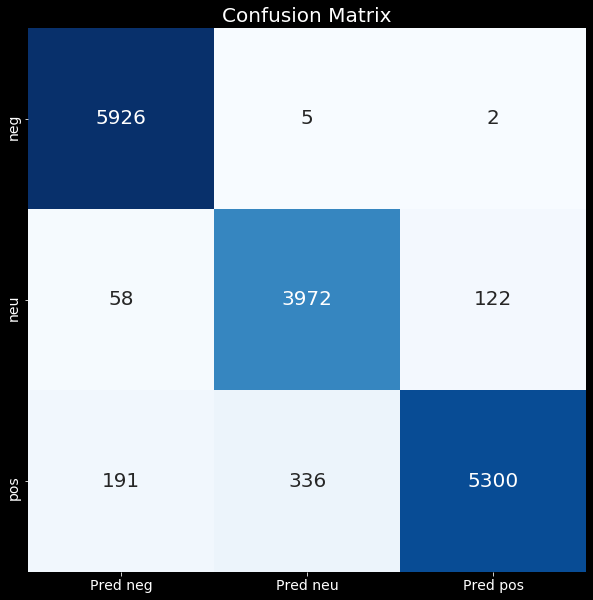

In [401]:
conmat = np.array(confusion_matrix(y_test, rf.predict(X_test_dtm)))

confusion = pd.DataFrame(conmat, index=['neg', 'neu', 'pos'],\
                     columns=['Pred neg', 'Pred neu', 'Pred pos'])

plt.figure(figsize = (10,10))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20}, cmap='Blues',fmt='g', cbar=False)

plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix", fontsize=20)
plt.style.use('dark_background');